## NSMC를 딥러닝으로 해보자!

* 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [1]:
def mecab_nouns(text):
    nouns = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+")
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
    
    # 추출한 token중에 POS가 명사 분류에 속하는 토큰만 선택.
    for token in temp:
        if token[1] == "NNG" or token[1] == "NNP" or token[1] == "NNB" or token[1] == "NNBC" or token[1] == "NP" or token[1] == "NR" :
            nouns.append(token[0])
    
    return nouns

def mecab_morphs(text):
    morphs = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+")
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
    
    # 추출한 token중에 문자열만 선택.
    for token in temp:
        morphs.append(token[0])
    
    return morphs

# mecab.pos() # MAC
def mecab_pos(text):
    pos = []
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+")
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    pos = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]    
    
    return pos

In [2]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
        
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

In [3]:
#from konlpy.tag import Mecab
import MeCab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

okt = Okt()
mecab = MeCab.Tagger()

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(line[1])]
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(line[1])]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['평점', '나쁘', '지만', '짜리', '더더욱', '아니', '잖아'], '0']


In [4]:
print(train_data[:3])

[[['진짜', '짜증', '네요', '목소리'], '0'], [['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나'], '1'], [['너무', '밓었다그래서보는것을추천한다'], '0']]


* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

## Deep Neural Network로 분류하기

In [5]:
# 필요한 라이브러리 불러오기
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Set Hyperparameter 

In [6]:
max_words = 35000
max_len = 30
batch_size = 128 
EPOCHS = 4

## Define Network Structure 

In [7]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb = Embedding(max_words, 100)
        self.lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)
        self.dense = Dense(1, activation="sigmoid")
        
    def __call__(self, x, training=None, mask=None):
        x = self.emb(x)
        x = self.lstm(x)
        return self.dense(x)

## Data Preprocessing 

In [8]:
# SVM 때와 비슷한 형태로 만들고
x_train = [doc for doc, _ in train_data]

# keras가 사용하기 위한 형태로 Tokenizing
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

# LSTM의 input으로 넣기 위한 변환 작업
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences([doc for doc, _ in test_data])
y_train = np.array([int(label) for _, label in train_data])
y_test = np.array([int(label) for _, label in test_data])
print(x_train[0])

# 크기를 맞춰주기 위한 zero padding
x_train = pad_sequences(x_train, value = 0, padding='pre', maxlen=max_len) # 패딩을 0으로 채워라(default도 0)
x_test = pad_sequences(x_test, value = 0, padding='pre', maxlen=max_len)
print("\n", x_train[0])

# 학습 가능한 형태로 최종 변환.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[9, 110, 7, 456]

 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   9 110   7 456]


## Set Model 

In [9]:
# 모델 선언
model = SimpleLSTM()
# 모델 컴파일
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

## Early Stopping Callback

In [10]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)

## Run Model 

In [11]:
# 실행, 결과 저장.
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[earlystopper])

Epoch 1/4
1145/1145 [==============================] - 106s 90ms/step - loss: 0.4152 - accuracy: 0.8055 - val_loss: 0.3855 - val_accuracy: 0.8219
Epoch 2/4
1145/1145 [==============================] - 111s 97ms/step - loss: 0.3291 - accuracy: 0.8545 - val_loss: 0.3910 - val_accuracy: 0.8241
Epoch 3/4
1145/1145 [==============================] - 110s 96ms/step - loss: 0.2732 - accuracy: 0.8812 - val_loss: 0.4330 - val_accuracy: 0.8186
Epoch 4/4
1145/1145 [==============================] - 113s 99ms/step - loss: 0.2238 - accuracy: 0.9041 - val_loss: 0.5011 - val_accuracy: 0.8142


In [12]:
# Model Test
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)

382/382 [==============================] - 6s 16ms/step - loss: 0.5011 - accuracy: 0.8142


In [13]:
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Test Score:  0.5010774731636047
Test Accuracy:  0.8142032623291016


## Loss Visualization 

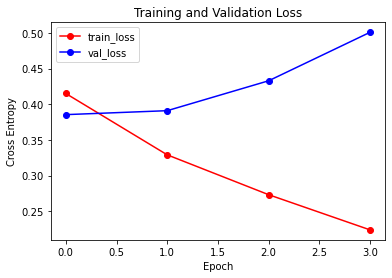

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label="train_loss")
plt.plot(val_loss, 'bo-', label="val_loss")
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Training and Validation Loss')
plt.show()

## Save Weight 

In [15]:
# Model weight matrix 저장.
model.save_weights("nsmc_keras_simplelstm")